# Science frame correction 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from astropy.io import fits 
import pickle 

It's time to load the science file list:

In [2]:
science_list = np.genfromtxt('../data/data.list', dtype=str)

## Testing the code on a subset of images

We will test our reduction pipeline and tools to extract aperture photometry only on a small subsample of images. \
Reducing and saving all the images will take more space than the one available on the computer. 
In this example, I will use only the first ten images.

In [3]:
science_test_list = science_list[:10]
science_test_fits = fits.open('../data/'+ science_list[0])
science_test_fits_0 = science_test_fits[0]
science_test_fits_0.header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  521 / length of data axis 1                          
NAXIS2  =                  222 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
DATE    = '2019-12-29T18:33:07' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
FILENAME= 'AF578220.fits'      / Original file name                             
TIMESYS = 'UTC     '        

## Data reduction steps

Science data reduction includes these steps:
1) multiplication by gain
2) bias subtraction
3) division by flat 

These components contribute to the error budget:
- readout noise
- error associated with the bias
- error associated with the flat
- photon noise



We load the median bias and the median normalized flat (with its error) \
We must use the same bias error and readout noise estimates we used for the flat correction. 

In [4]:
median_bias = pickle.load(open("output_files/median_bias.p", "rb"))
bias_std = 1.3 # [e] photoelectrons
readout_noise = 7.4  # [e] photoelectrons
gain = 1.91 # [e/ADU]  # this value may be 
median_normalized_flat =  pickle.load(open("output_files/median_normalized_flat.p", "rb"))
median_normalized_flat_errors =  pickle.load(open("output_files/median_normalized_flat_errors.p", "rb"))

For the photon noise, we can rely on Poissonian distribution as done with the flat.
Remember that the photon noise must be computed *after* removing the bias but *before* correcting for the flat field, as the error must be calculated on the actual number of photons received on the detector, not on the photons emitted by the source.


In [5]:
for science_name in science_test_list:
    science_fits = fits.open('../data/' + science_name)
    science_data = science_fits[0].data * gain # save the data from the first HDU 
    science_fits.close()

    science_debiased = science_data - median_bias
    science_corrected = science_debiased / median_normalized_flat

    ## Error associated to the science corrected frame
    science_debiased_errors = np.sqrt(readout_noise**2 + bias_std**2 + science_debiased)
    science_corrected_errors = science_corrected * np.sqrt((science_debiased_errors/science_debiased)**2 + (median_normalized_flat_errors/median_normalized_flat)**2)


/tmp/ipykernel_26883/2762310329.py:7: RuntimeWarning: divide by zero encountered in divide
  science_corrected = science_debiased / median_normalized_flat
/tmp/ipykernel_26883/2762310329.py:7: RuntimeWarning: invalid value encountered in divide
  science_corrected = science_debiased / median_normalized_flat
/tmp/ipykernel_26883/2762310329.py:11: RuntimeWarning: divide by zero encountered in divide
  science_corrected_errors = science_corrected * np.sqrt((science_debiased_errors/science_debiased)**2 + (median_normalized_flat_errors/median_normalized_flat)**2)
/tmp/ipykernel_26883/2762310329.py:11: RuntimeWarning: invalid value encountered in multiply
  science_corrected_errors = science_corrected * np.sqrt((science_debiased_errors/science_debiased)**2 + (median_normalized_flat_errors/median_normalized_flat)**2)


Do not worry if you run into this warning, as it is likely due to the presence of zero values in the overscan region of the flat: \
`RuntimeWarning: divide by zero encountered in divide`

Remember the difference between a *warning* and an *error*: 
- **warning**: Something has not worked as it should. The code keeps running, but you should investigate the origin of the warning and decide if it is relevant or if it can be ignored.
- **error**: Something *serious* has gone wrong and the code stopped running

For now we keep the warnings, but we may want to suppress them when running the analysis over thousands of images. The official Python documentation helps us in 
[temporarily suppressing warnings](https://docs.python.org/3/library/warnings.html#temporarily-suppressing-warnings) and 
[completely suppressing the warnings](https://docs.python.org/3/library/warnings.html#overriding-the-default-filter)

## Saving the images 

We now repeat the same steps again, but this time, we save the output into a file. \
First of all, from the terminal let's make a directory where to store the new files. \
```bash
mkdir correct
```
Be sure to be in the same folder where you launched the Jupyter Notebbok.

We want to use the same names of the files for our new frames, without the  `.fits` extension. The extension is made by five characters, i.e., we can take the string identifying each file name and remove the last five characters. In Python notation:
```python
science_name[:-5]
```
The new file name is made by adding new string characters at the beginning and at the end of the original name:

```python
new_name = './correct/' + science_name[:-5] + '_corr.p'
```

In [6]:
print(science_name)
print(science_name[:-5])
new_name = science_name[:-5] + '_corr.p'
print(new_name)

AF578229.fits
AF578229
AF578229_corr.p


In [7]:

for science_name in science_test_list:
    science_fits = fits.open('../data/' + science_name)
    science_data = science_fits[0].data * gain # save the data from the first HDU 
    science_fits.close()
    
    science_debiased = science_data - median_bias
    science_corrected = science_debiased / median_normalized_flat

    ## Error associated to the science corrected frame
    science_debiased_errors = np.sqrt(readout_noise**2 + bias_std**2 + science_debiased)
    science_corrected_errors = science_corrected * np.sqrt((science_debiased_errors/science_debiased)**2 + (median_normalized_flat_errors/median_normalized_flat)**2)

    new_name = '../corrected_files/' + science_name[:-5] + '_corr.p'
    pickle.dump(science_corrected, open(new_name, 'wb'))
    new_name = '../corrected_files/' + science_name[:-5] + '_corr_errors.p'
    pickle.dump(science_corrected_errors, open(new_name, 'wb'))
    


/tmp/ipykernel_26883/3033028492.py:7: RuntimeWarning: divide by zero encountered in divide
  science_corrected = science_debiased / median_normalized_flat
/tmp/ipykernel_26883/3033028492.py:7: RuntimeWarning: invalid value encountered in divide
  science_corrected = science_debiased / median_normalized_flat
/tmp/ipykernel_26883/3033028492.py:11: RuntimeWarning: divide by zero encountered in divide
  science_corrected_errors = science_corrected * np.sqrt((science_debiased_errors/science_debiased)**2 + (median_normalized_flat_errors/median_normalized_flat)**2)
/tmp/ipykernel_26883/3033028492.py:11: RuntimeWarning: invalid value encountered in multiply
  science_corrected_errors = science_corrected * np.sqrt((science_debiased_errors/science_debiased)**2 + (median_normalized_flat_errors/median_normalized_flat)**2)


## Extracting and saving useful information

For our analysis, we need to know **when** the data has been taken, not just how. In addition, we may need some extra information regarding the pointing of the telescope.
- The epoch of the exposure, expressed in Julian date
- The exposure time, i.e., the duration of our exposure
- The airmass of the telescope during the exposure

We extract this information from the header of each fits file.
Other info you may need, e.g., the filter used for the observations, do not change with time  so you just need to extract them from a single frame. 

In [8]:
n_images = len(science_test_list)

array_jd = np.zeros(n_images)
array_exptime = np.zeros(n_images)
array_airmass = np.zeros(n_images)

for i_science, science_name in enumerate(science_test_list):

    science_fits = fits.open('../data/'+science_name)    
    array_jd[i_science] = science_fits[0].header['JD']
    array_exptime[i_science] = science_fits[0].header['EXPTIME']
    array_airmass[i_science] = science_fits[0].header['AIRMASS']

    ## Let's print the comment for the first image
    if i_science==0:
        print('',science_fits[0].header.comments['JD'])
        print('',science_fits[0].header.comments['EXPTIME'])
        print('',science_fits[0].header.comments['AIRMASS'])
    
    science_fits.close()

 JD at start
 [s] Exposure time
 Telescope airmass at start


## Conversion to BJD_TDB

Did you notice that the Julian Date is expressed as JD and not BJD, i.e., *Barycentric Julian Date*?
This is the time when an event is recorded at the observatory. What we want in reality is the time as recorded at the Barycenter of the Solar System, as we do not want to be influenced by the specific position of the observatory when the observations are taken.

Check the story of how the Danish astronomer Ole Roemer (1644–1710) became the first person to measure the speed of light in 1676, to see how the position of the observer may influence your results.

The correction is done through several steps:
1) We want each time stamp to be associated with the centre of the exposure, not the initial moment. We have to shift all the time stamps by half the exposure time
2)  We have to shift from [Coordinated Universal Time (UTC)](https://en.wikipedia.org/wiki/Coordinated_Universal_Time) (a discontinuous scale due to the introduction of leap seconds) to the [Barycentric Dynamical Time (TDB)](https://en.wikipedia.org/wiki/Barycentric_Dynamical_Time), a relativistic coordinate time scale defined on the barycenter of the Solar system.
3)  We have to correct for the *light travel time* effect, i.e.,  the time required by the light to travel between Earth (specifically, our observatory and the Solar System barycenter

We rely on the `Time` package of `Astropy` to perform all these calculations. Check [the documentation](#https://docs.astropy.org/en/stable/time/) for more examples.
We also need to specify an Astronomical Coordinate System for our target as required by the Astropy package. For this purpose, we rely on the [`coordinates`](https://docs.astropy.org/en/stable/coordinates/index.html) package.

In [9]:
from astropy import coordinates as coord, units as u
target = coord.SkyCoord('06:30:32.80', '+29:40:20.26', unit=(u.hourangle, u.deg), frame='icrs')
print(target)
print(type(target))
print(target.shape)

<SkyCoord (ICRS): (ra, dec) in deg
    (97.63666667, 29.67229444)>
<class 'astropy.coordinates.sky_coordinate.SkyCoord'>
()


Let's make a plot of the light travel time correction along one year, for our target:

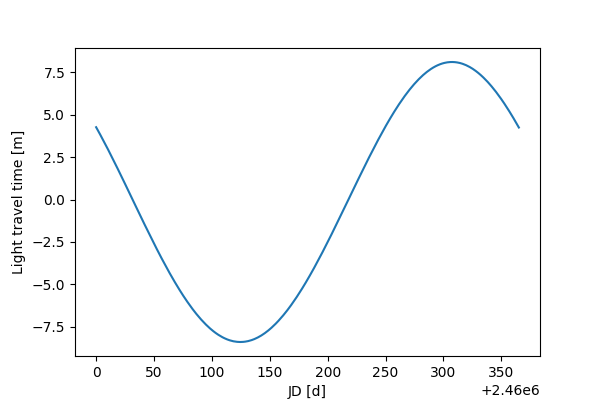

In [10]:
from astropy.time import Time
#https://docs.astropy.org/en/stable/time/

# let's compute the light travel time for one year of observations 
jd_plot = np.arange(2460000, 2460365.25, 0.10)
tm_plot = Time(jd_plot, format='jd', scale='utc', location=('45.8472d', '11.569d')) 
ltt_plot = tm_plot.light_travel_time(target)

plt.figure(figsize=(6,4))
plt.plot(jd_plot, ltt_plot.to_value(u.min))
plt.xlabel('JD [d]')
plt.ylabel('Light travel time [m]')
plt.show()




### Important addition with respect to the lecture:

During the lectures I got a bit confused because in my notes I was applying  the Light Travel Time correction directly to the JD (UTC), which in principle should be wrong. After checking the documentation, I realized that the [`light_travel_time`](https://docs.astropy.org/en/stable/api/astropy.time.Time.html#astropy.time.Time.light_travel_time) method takes care of doing the conversion to BJD_TDB as a `TimeDelta` object, so the correct way to proceed is to add the value of `TimeDelta` directly to our JD array.

**light_travel_time**(skycoord, kind='barycentric', location=None, ephemeris=None) \
Light travel time correction to the barycentre or heliocentre.

The frame transformations used to calculate the location of the solar system barycentre and the heliocentre rely on the erfa routine epv00, which is consistent with the JPL DE405 ephemeris to an accuracy of 11.2 km, corresponding to a light travel time of 4 microseconds.

The routine assumes the source(s) are at large distance, i.e., neglects finite-distance effects.

**Returns**: *time_offset* TimeDelta \
The time offset between the barycentre or Heliocentre and Earth, in TDB seconds. Should be added to the original time to get the time in the Solar system barycentre or the Heliocentre. Also, the time conversion to BJD will then include the relativistic correction as well.

Below, we compute the JD_UTC at mid exposure before converting to BJD_TDB

In [11]:
jd = array_jd + array_exptime/86400./2. 

tm = Time(jd, format='jd', scale='utc', location=('45.8472d', '11.569d')) 

# Asiago - Cima Ekar
# 45° 50' 50'' N -> 45.8472
# 11° 34' 08'' E -> 11.569

ltt_bary = tm.light_travel_time(target)  

bjd_tdb = jd + ltt_bary.to_value(u.day)

print('Light travel time in minutes:')
print(ltt_bary.to_value(u.min))


Light travel time in minutes:
[8.19139058 8.19139048 8.19139039 8.19139029 8.1913902  8.1913901
 8.19139001 8.19138991 8.19138982 8.19138972]


## Identification of the target and reference stars
Open a scientific frame and display it in order to identify the target star (the one with the transiting planet) and the reference stars (used to do differential photometry). You will need to use [SIMBAD](https://simbad.cds.unistra.fr/simbad/) for a correct identification. \
You can play with the `vmin` and `vmax` value to highlight fainter stars. 

vmin:  857.9    vmax: 80367.5


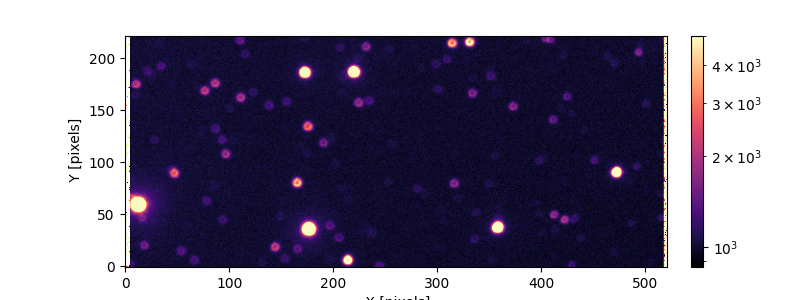

In [12]:
science_frame_name = '../corrected_files/' + science_test_list[0][:-5] + '_corr.p'
science_corrected = pickle.load(open(science_frame_name, 'rb'))

import matplotlib.colors as colors

vmin = np.amin(science_corrected[:,100:400])
vmax = np.amax(science_corrected[:,100:400])
print('vmin:  {0:.1f}    vmax: {1:.1f}'.format(vmin, vmax))
vmax = 5000

fig, ax = plt.subplots(1, figsize=(8,3))
im1 = plt.imshow(science_corrected, cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
plt.colorbar(im1,ax=ax, fraction=0.046, pad=0.04)
plt.xlabel(' X [pixels]')
plt.ylabel(' Y [pixels]')
plt.show()

You can get an approximate location by rolling the mouse over the star and taking note of the numbers displayed in the lower part of the frame. These are the values that I got:

In [13]:
x_target = 357.1
y_target = 37.6

x_reference_01 = 471.5
y_reference_01 = 91.0

You don't need to be extremely precise in defining the centers, at this stage. We can get a better refinement by drawing a circle around each star. To spped upo the process, I wrapped the plotting routines inside a function:

In [14]:
def make_circle_around_star(x_pos, y_pos, label='', color='w'):
    from matplotlib.patches import Circle

    n, radii = 50, [9, 15]
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))
    
    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]
    
    ax.fill(np.ravel(xs)+x_pos, np.ravel(ys)+y_pos, edgecolor=None, facecolor=color, alpha=0.75, label=label)


Thanks to the function, you can draw as many circles as you want by simply adding one line of code. Below, I ran the script several times, changing slightly the position of the circles every time, until they were well centered around the star (Note: integer values are fine)

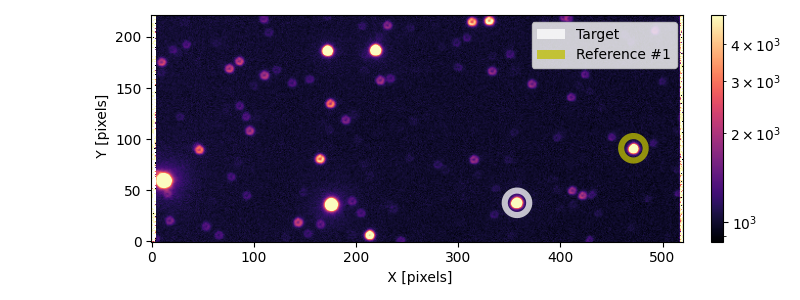

In [15]:
x_target = 357.5
y_target = 37.6

x_reference_01 = 471.5
y_reference_01 = 91.0


fig, ax = plt.subplots(1, figsize=(8,3))
im1 = plt.imshow(science_corrected, cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
plt.colorbar(im1,ax=ax, fraction=0.046, pad=0.04)

make_circle_around_star(x_target, y_target, label='Target', color='w')
make_circle_around_star(x_reference_01, y_reference_01, label='Reference #1', color='y')
plt.xlabel(' X [pixels]')
plt.ylabel(' Y [pixels]')
ax.legend()
plt.tight_layout()
plt.show()